In [11]:
# ===============================================================
# Notebook: Regresión Logística - Telco Customer Churn
# Este notebook desarrolla todo el flujo: carga de datos, limpieza,
# preprocesamiento, entrenamiento del modelo y métricas finales.
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)

import joblib

# Cargar dataset
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
# =============================
# Limpieza inicial
# =============================

# Eliminar filas con valores nulos en TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(subset=["TotalCharges"], inplace=True)

# Eliminar columnas irrelevantes
df.drop(columns=["customerID"], inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [13]:
# ================================================
# Convertir target a binario
# ================================================
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# One-hot encoding para todas las categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

df_encoded.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [14]:
# ===========================
# Separar características y target
# ===========================
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

# Guardar el orden REAL de columnas (importante para la app)
columnas_finales = X.columns.tolist()
joblib.dump(columnas_finales, "../modelos/telco_columns.pkl")

len(columnas_finales), columnas_finales[:10]


(30,
 ['SeniorCitizen',
  'tenure',
  'MonthlyCharges',
  'TotalCharges',
  'gender_Male',
  'Partner_Yes',
  'Dependents_Yes',
  'PhoneService_Yes',
  'MultipleLines_No phone service',
  'MultipleLines_Yes'])

In [15]:
# ===================================================
# División Train/Test
# ===================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Estandarización (solo variables numéricas)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler para la app
joblib.dump(scaler, "../modelos/scaler_telco.pkl")


['../modelos/scaler_telco.pkl']

In [16]:
# ===========================
# Entrenar modelo
# ===========================
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Guardar modelo entrenado
joblib.dump(log_model, "../modelos/logistic_model.pkl")


['../modelos/logistic_model.pkl']

In [17]:
# ===============================
# Predicciones
# ===============================
y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1


(0.8038379530916845,
 0.6475903614457831,
 0.5748663101604278,
 0.6090651558073654)

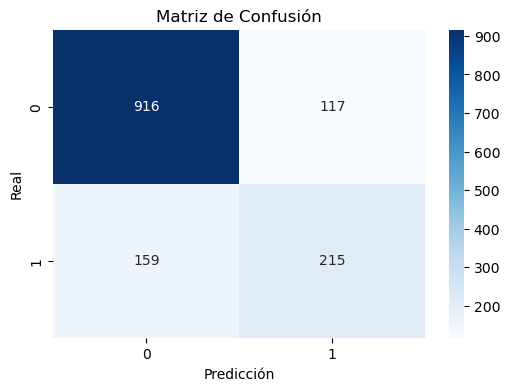

In [18]:
# ===========================
# Matriz de confusión
# ===========================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


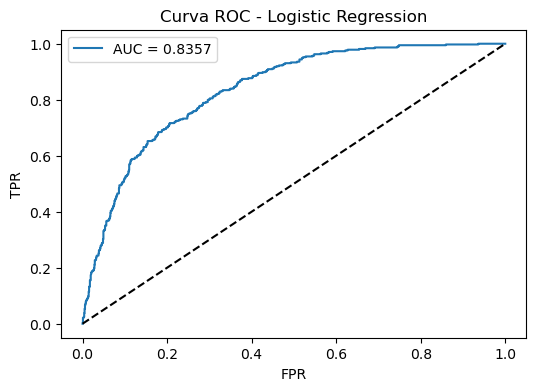

In [19]:
# ===========================
# Curva ROC
# ===========================
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Curva ROC - Logistic Regression")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


In [20]:
print("========= RESULTADOS DEL MODELO =========")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


========= RESULTADOS DEL MODELO =========
Accuracy:  0.8038
Precision: 0.6476
Recall:    0.5749
F1-score:  0.6091
AUC:       0.8357
